In [54]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    infected = infectionData[:,1]
    tested = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    tested = tested.astype(float)
    infected = infected.astype(float)
    return dates, infected, tested, recovered, deaths

def plotQ(infected, tested, recovered, dead, pop, qMin = .001, qMax = 1, resol = 100, w = .9, lamda=10):
    qList = np.zeros(resol)
    minCostList = np.zeros(resol)
    for i in range(resol):
        qList[i] = qMin + (i/resol)*(qMax-qMin) #go from 0 to 1

    lamda = 10
    model = linear_model.Lasso(alpha=lamda)

    for i in range(resol):
        suscept = qList[i]*pop - infected - recovered - dead
        nextIterMatrix, sirdMatrix= getSIRDMatrices(suscept, infected, recovered, dead)
        T = np.shape(sirdMatrix)[2]
        paramMatrix = np.zeros((3, T))
        totalLoss = 0
        for t in range(T):
            model.fit(sirdMatrix[:,:,t], nextIterMatrix[:,:,t])
            paramMatrix[:,t] = model.coef_

            iterLoss = w**(T-t) * np.linalg.norm(nextIterMatrix[:,:,t] - sirdMatrix[:,:,t]*paramMatrix[:,t], ord=2)**2 + lamda*np.linalg.norm(paramMatrix[:,t], ord=1)
            totalLoss = totalLoss + iterLoss

        totalLoss = totalLoss / (T)
        minCostList[i] = totalLoss

    bestQIndex = 0
    for i in range(resol):
        if(minCostList[bestQIndex] > minCostList[i]):
            bestQIndex = i

    print("best q:", qList[bestQIndex])

    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(qList, minCostList, color='blue')
    return qList[bestQIndex]

def showCurves(infected, tested, recovered, dead, pop, q, lamda=10):
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*pop - infected - recovered - dead
    
    nextIterMatrix, sirdMatrix = getSIRDMatrices(suscept, infected, recovered, dead)

    T = np.shape(sirdMatrix)[2]
    paramMatrix = np.zeros((3, T))
    model = linear_model.Lasso(alpha=lamda)
    for t in range(T):
        model.fit(sirdMatrix[:,:,t], nextIterMatrix[:,:,t])
        paramMatrix[:,t] = model.coef_
    #paramMatrix = np.zeros((3, np.shape(sirdMatrix)[2]))
    #for i in range(np.shape(sirdMatrix)[2]):
    #    paramMatrix[:,i] = np.linalg.lstsq(sirdMatrix[:,:,i], nextIterMatrix[:,:,i], rcond=0)[0].flatten() #solve Ax = B, where A = sirdMatrix, and B = nextIterMatrix
    
    #copy params over from the solved matrix
    transRate = paramMatrix[0] #beta
    recovRate = paramMatrix[1] #gamma
    deathRate = paramMatrix[2] #upsilon

    
    fig, ax = plt.subplots(3, 1, figsize=(18,10))

    x=range(0, len(transRate))
    xPlot = np.linspace(x[0], x[-1])

    poly = np.poly1d(np.polyfit(x, transRate, 2))
    yPlot = poly(xPlot)
    ax[0].plot(xPlot, yPlot, color='orange', label='Transmission Rate')
    ax[0].set_ylabel('Beta')
    ax[0].set_xlabel('Time(Days)')
    poly = np.poly1d(np.polyfit(x, recovRate, 2))
    yPlot = poly(xPlot)
    ax[1].plot(xPlot, yPlot, color='green', label='Recovery Rate')
    ax[1].set_ylabel('Gamma')
    ax[1].set_xlabel('Time(Days)')
    poly = np.poly1d(np.polyfit(x, deathRate, 2))
    yPlot = poly(xPlot)
    ax[2].plot(xPlot, yPlot, color='black', label='Death Rate')
    ax[2].set_ylabel('Upsilon')
    ax[2].set_xlabel('Time(Days)')
    
    #plot rates over time
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
    #ax.plot(natTested, color = 'red', label = 'tested') #graphing tested makes the scaling hard to visualize
    ax.plot(infected, color='orange', label='infected')
    ax.plot(recovered, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    
    fig2, ax2 = plt.subplots(3, 1, figsize=(18,8))
    ax2[0].plot(transRate, color='orange', label='Transmission Rate')
    ax2[1].plot(recovRate, color='green', label='Recovery Rate')
    ax2[2].plot(deathRate, color='black', label='Death Rate')

def getSIRDMatrices(suscept, infect, recov, dead):
    sirdMatrix = np.zeros((4, 3, len(recov) - 1))
    nextIterMatrix = np.zeros((4, 1, len(recov) - 1)) #the S(t+1), I(t+1), ... matrix

    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[0,0] = -(suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])

    sirdMatrix[1,0] = (suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])
    sirdMatrix[1,1] = -infect[0:-1]
    sirdMatrix[1,2] = -infect[0:-1]

    sirdMatrix[2,1] = infect[0:-1]

    sirdMatrix[3,2] = infect[0:-1]

    #populate the S(t+1), I(t+1), ... matrix
    nextIterMatrix[0,0] = suscept[1:] - suscept[0:-1]
    nextIterMatrix[1,0] = infect[1:] - infect[0:-1]
    nextIterMatrix[2,0] = recov[1:] - recov[0:-1]
    nextIterMatrix[3,0] = dead[1:] - dead[0:-1]

    return nextIterMatrix, sirdMatrix


# National Data

best q: 0.01099


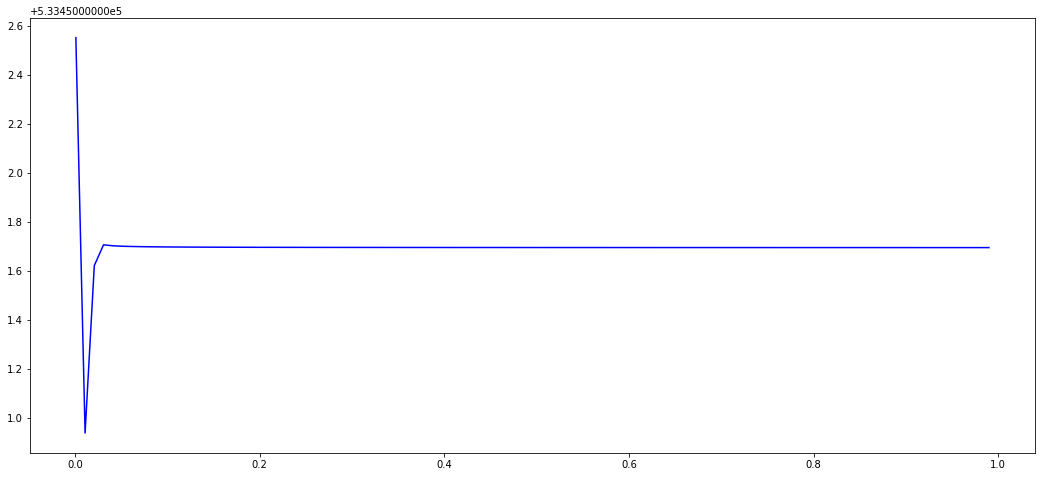

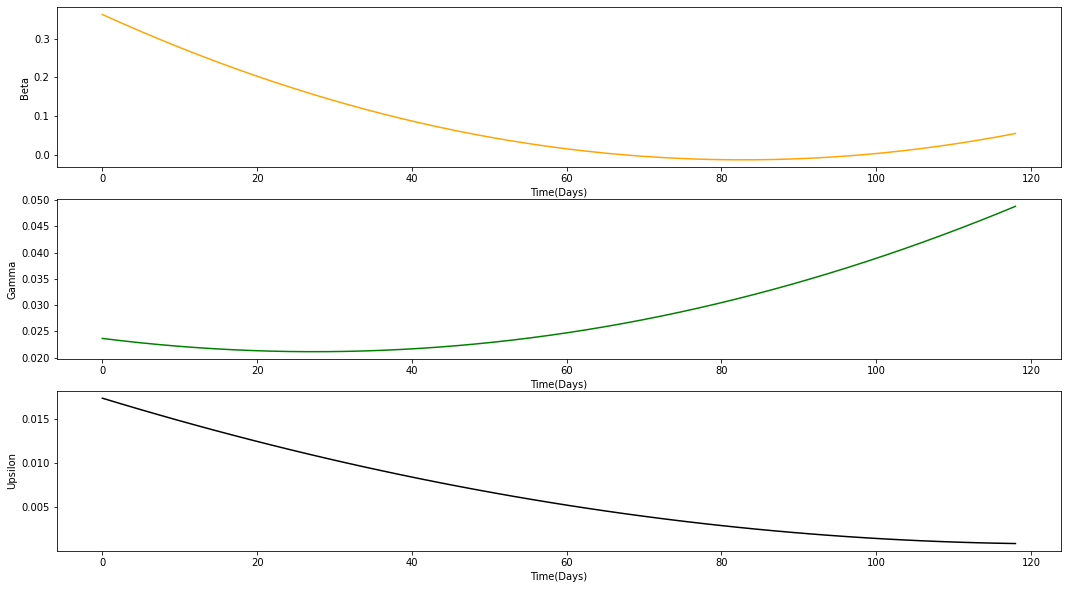

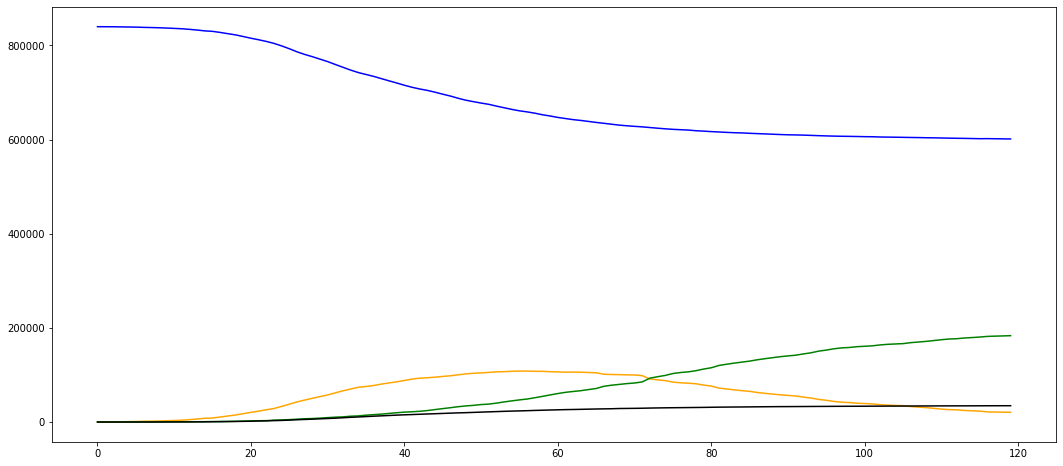

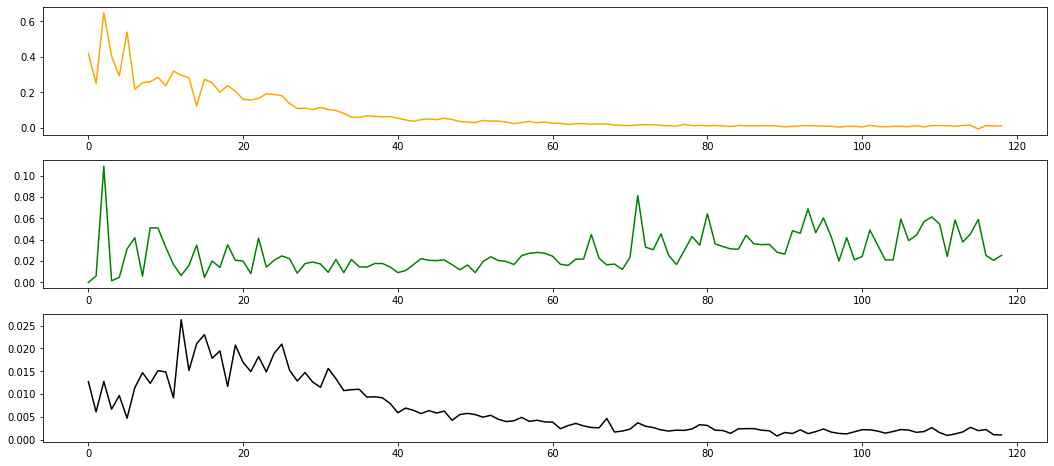

In [55]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "National Data.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)
q = plotQ(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 60000000)
showCurves(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 60000000, .014)

# Lombardia

best q: 0.020980000000000002


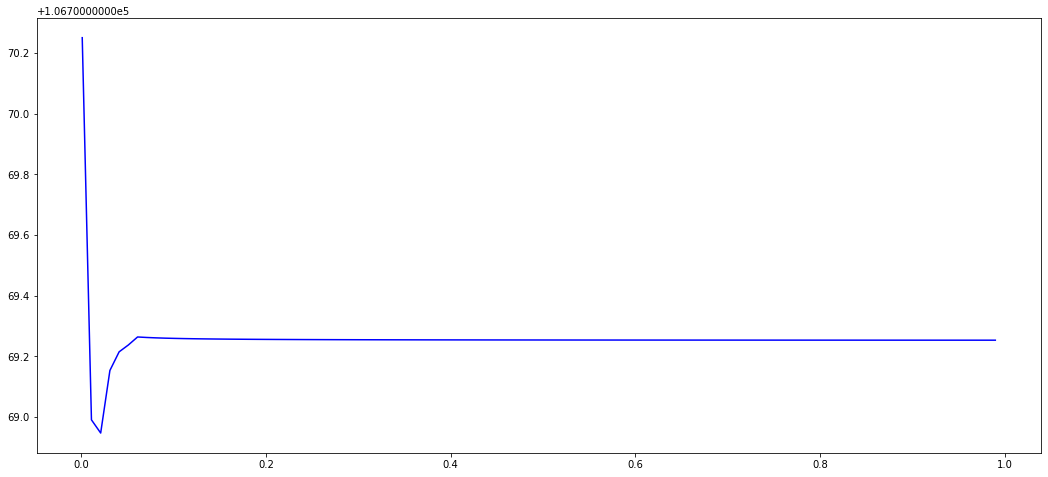

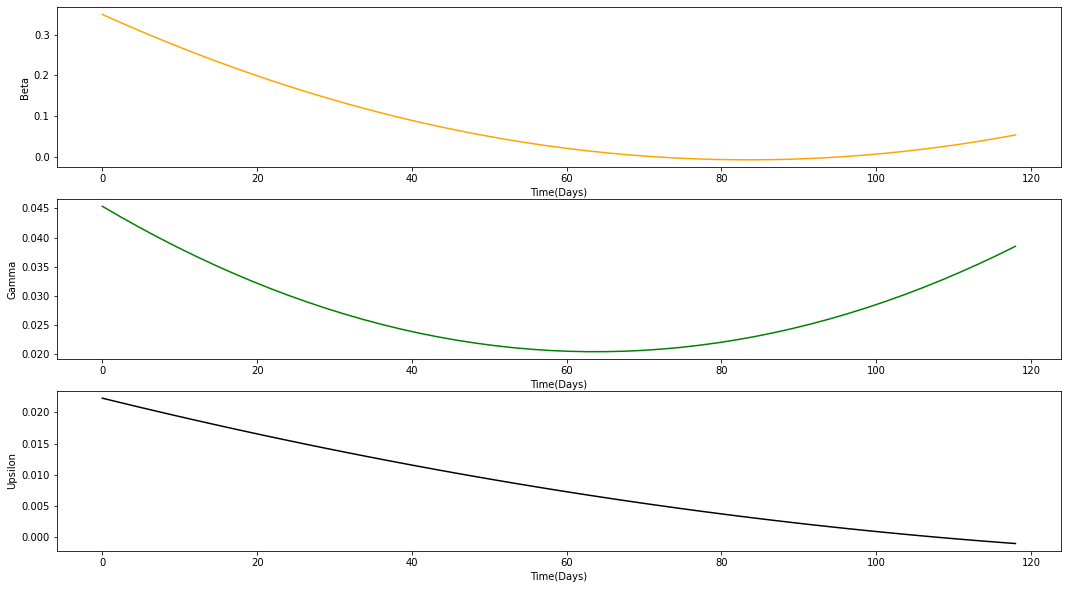

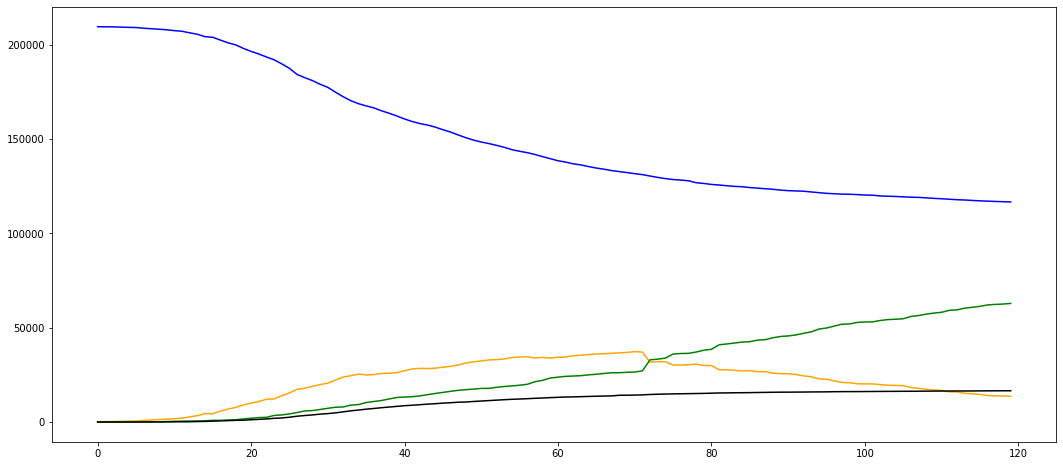

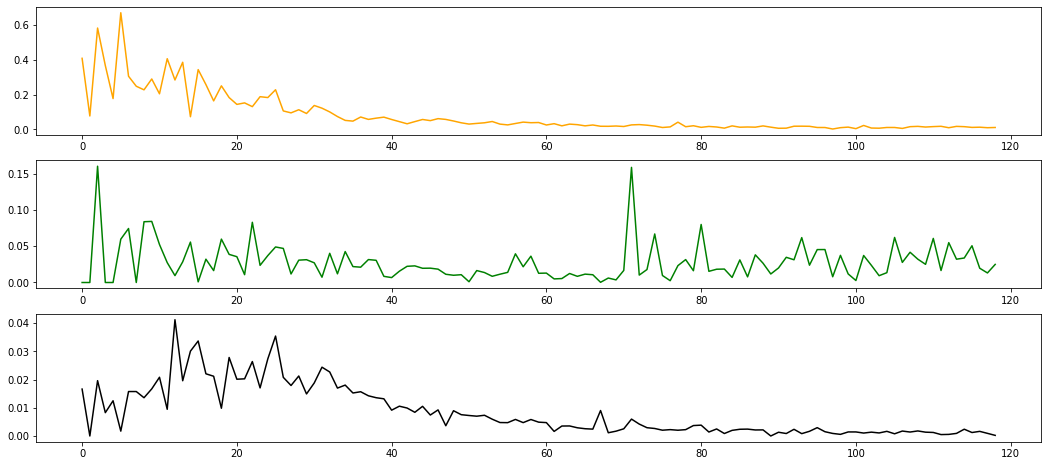

In [56]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "Lombardia.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)
q = plotQ(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 10000000)
showCurves(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 10000000, q)

# Piemonte

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0,

best q: 0.00698


C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


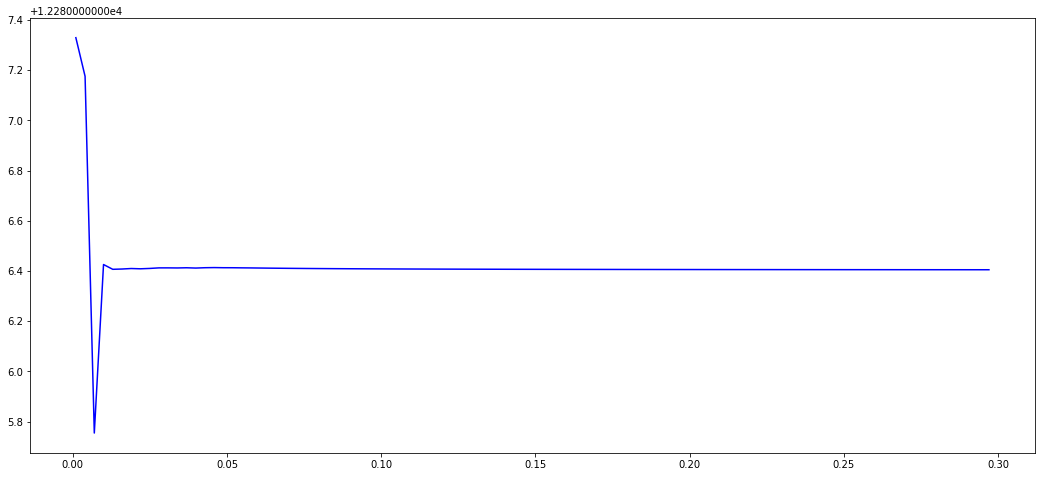

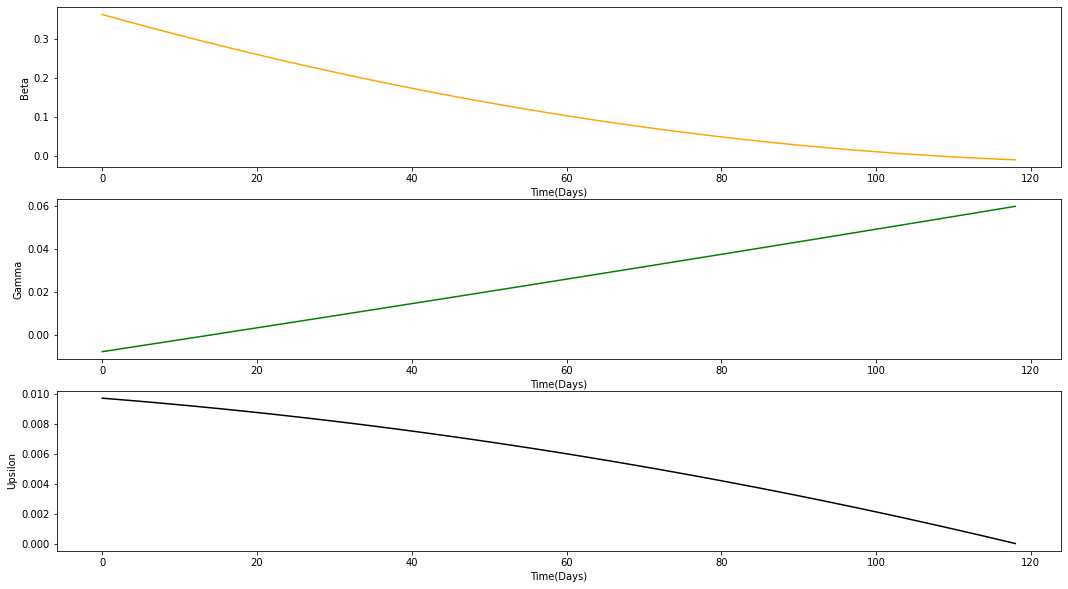

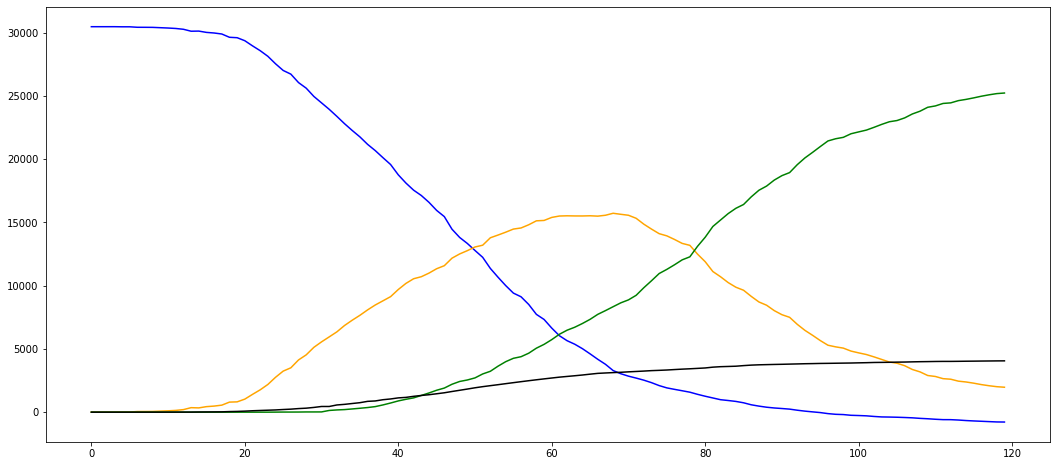

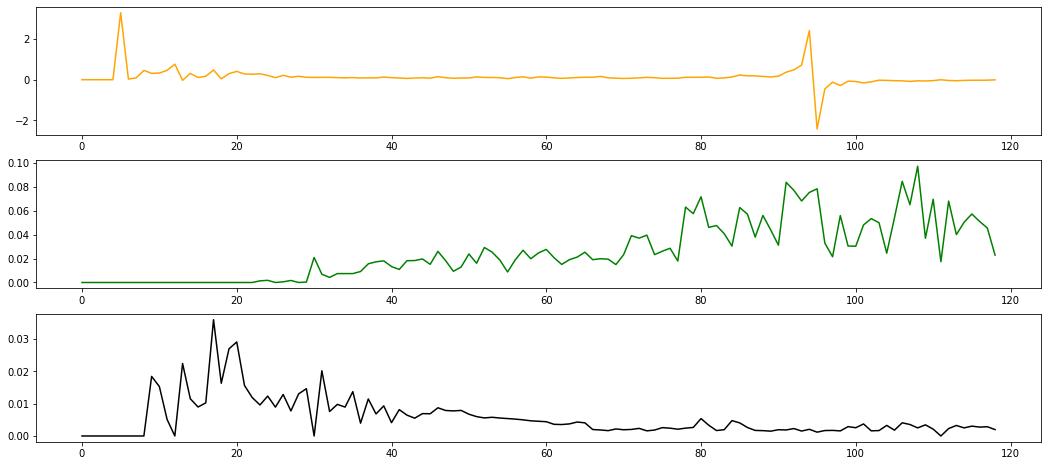

In [64]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "Piemonte.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)
q = plotQ(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 4365000, qMax = .3)
showCurves(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 4365000, q)

# Emilia Romanga

best q: 0.29701


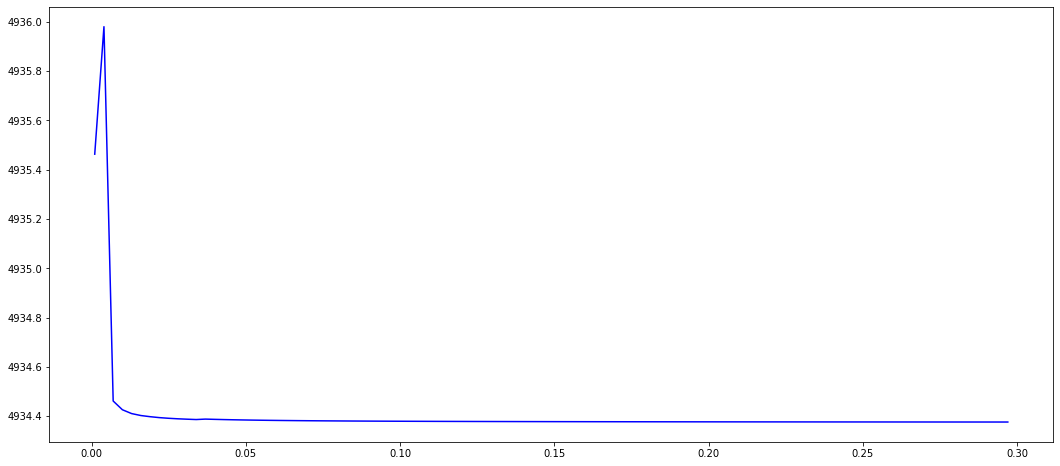

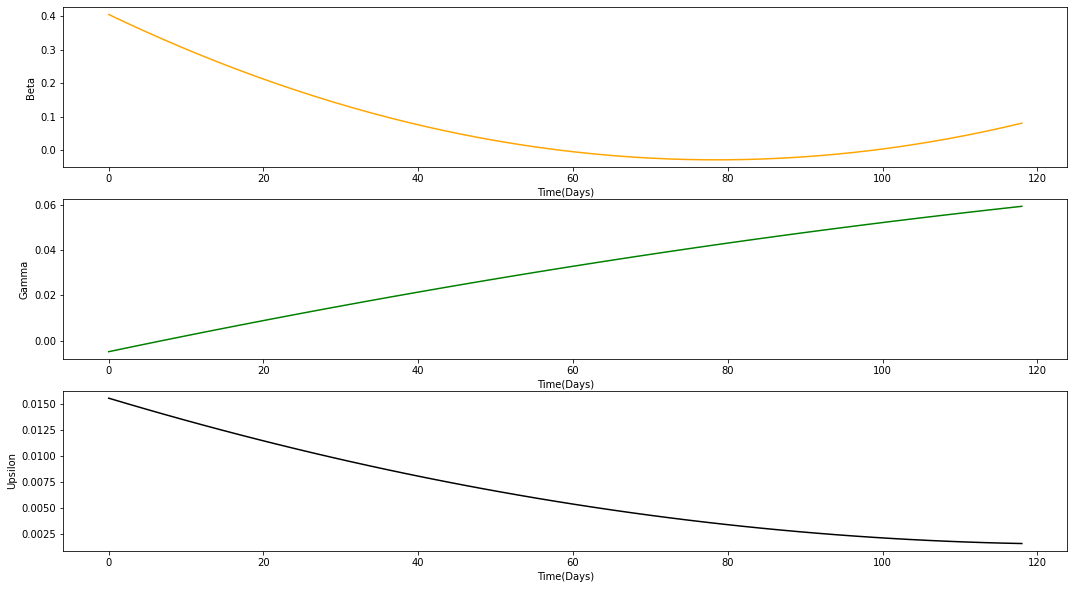

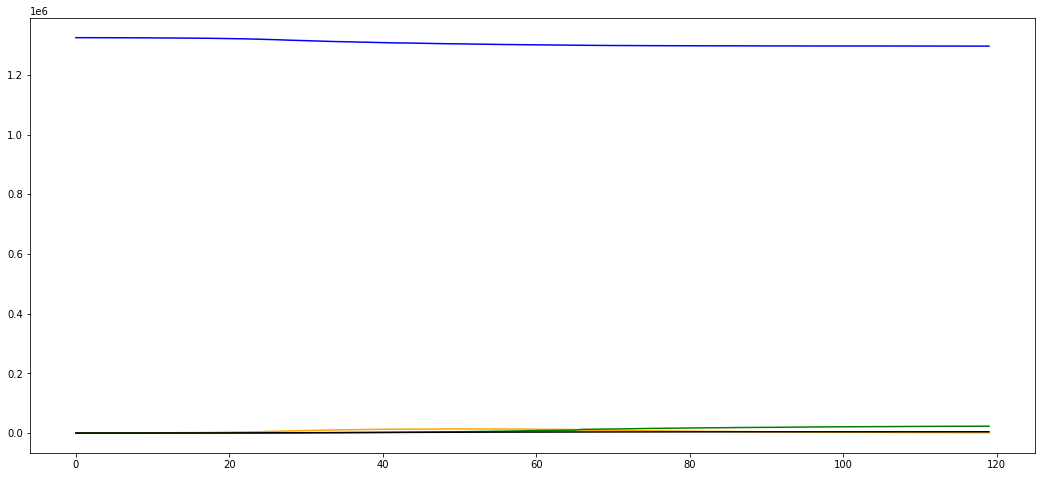

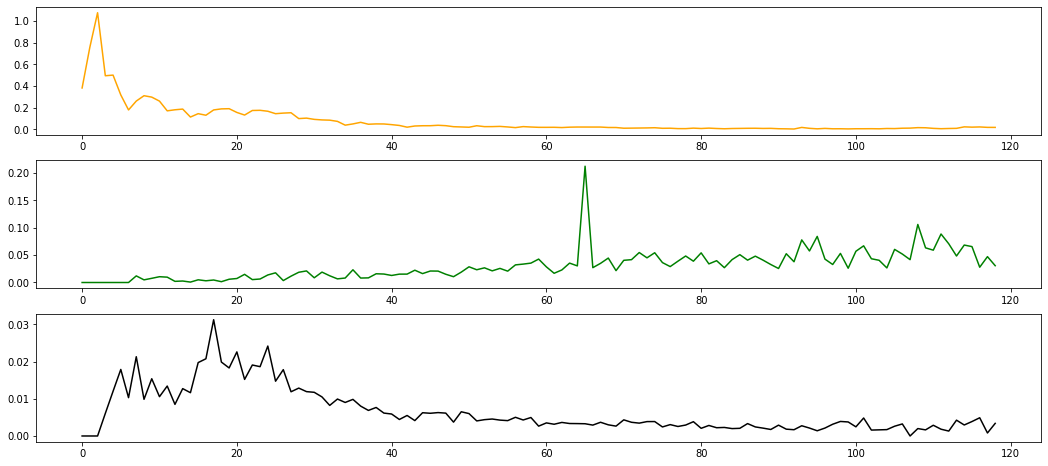

In [65]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "Emilia-Romanga.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)
q = plotQ(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 4459000, qMax = .3)
showCurves(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 4459000, q)

# Veneto

best q: 0.39601000000000003


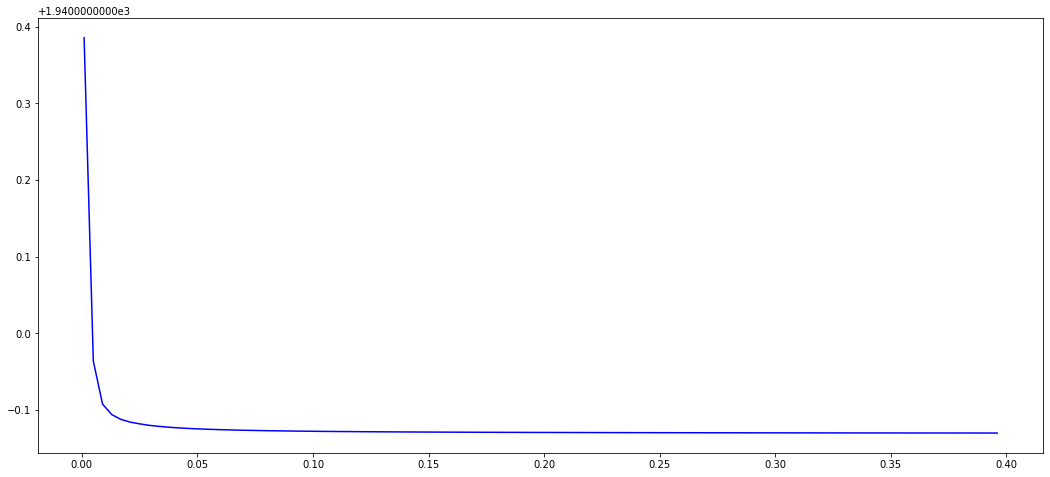

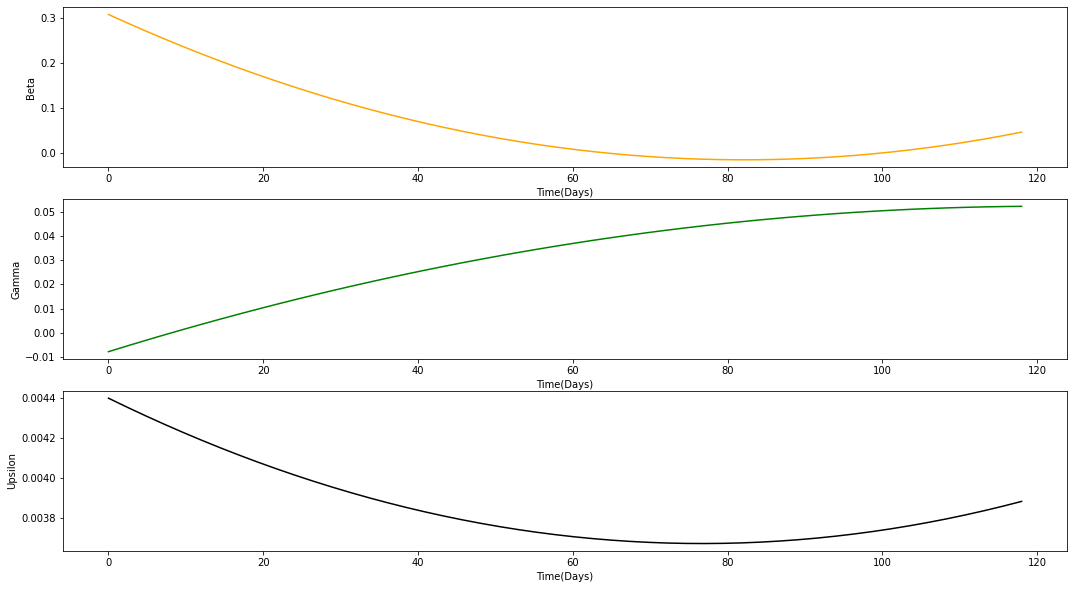

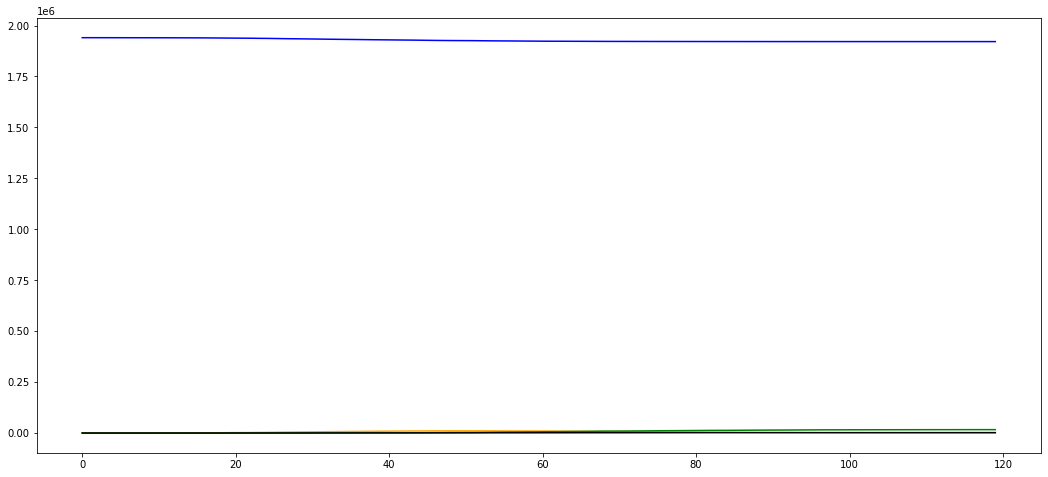

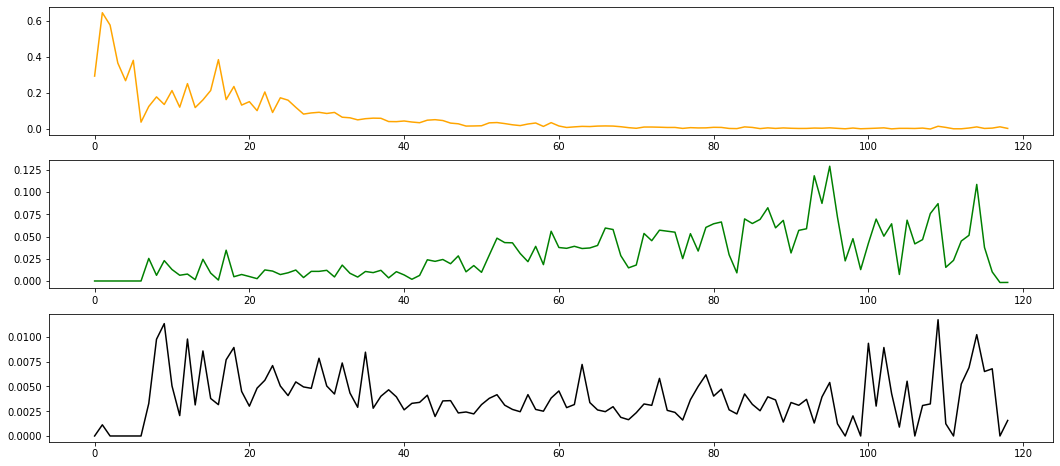

In [63]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "Veneto.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)
q = plotQ(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 4900000, qMax=.4)
showCurves(infectRaw[0:120],natTested[0:120],recovRaw[0:120], deadRaw[0:120], 4900000, q)